# Assignment 2
<a id='import-libraries'></a>
## Project Overview

This notebook demonstrates a comprehensive approach to bearing fault detection using signal processing and machine learning techniques. The analysis includes data loading, preprocessing, feature extraction, and preparation for clustering models.

### Table of Contents

1. [Import Libraries](#1-import-libraries)
2. [Data Loading](#2-data-loading)
3. [Data Preprocessing](#3-data-preprocessing)
4. [Feature Extraction](#4-feature-extraction)
5. [Segmentation & Feature Engineering](#5-segmentation--feature-engineering)
6. [Data Quality & Cleaning](#6-data-quality--cleaning)
7. [Feature Scaling & Encoding](#7-feature-scaling--encoding)
7. [Features Distribution](#8-features-distribution)
7. [Cluster Model](#9-cluster-model)

---

## 1. Import Libraries 

Import all necessary Python libraries for data processing, signal analysis, and machine learning.

In [1]:
# Core data processing and visualization
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Signal processing and analysis
from scipy import signal, stats
from scipy.io import loadmat
from scipy.fft import fft, fftfreq
from scipy.signal import butter, sosfilt, stft, welch
import pywt

# Machine learning and utilities
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from tqdm import tqdm

import gdown
import zipfile
import re

import matplotlib.pyplot as plt
import umap
import hdbscan
from mpl_toolkits.mplot3d import Axes3D


import warnings
warnings.filterwarnings('ignore')

# Visualization setup
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline
np.random.seed(42)

print("✓ Libraries loaded")

✓ Libraries loaded


## 2. Data Loading

Load and parse bearing vibration data from .mat files. The data includes different fault types and operating conditions.

In [2]:

# Download Google Drive ZIP, load .mat files into memory, delete ZIP
file_id = "1himbUCoQqLMq-J7E8JQl7sHcIcAWSHpk"
url = f"https://drive.google.com/uc?id={file_id}"
zip_path = "dataset.zip"

print("Downloading dataset from Google Drive...")
gdown.download(url, zip_path, quiet=False)


records = []
with zipfile.ZipFile(zip_path, 'r') as z:
    mat_files = [f for f in z.namelist() if f.endswith(".mat")]
    print(f"Found {len(mat_files)} .mat files in the ZIP")

    for fpath in tqdm(mat_files, desc="Loading .mat files"):
        try:
            with z.open(fpath) as mat_file:
                mat = loadmat(mat_file)
                sig = mat['data'].flatten()
                fs = mat.get('fs', [[51200]])[0][0]

                
                fname = os.path.basename(fpath).replace('.mat','')
                match = re.match(r"([A-Za-z]+)(\d+)(\d*)", fname)
                if match:
                    fault, bearing_digits, load_digits = match.groups()
                    bearing = f"620{bearing_digits[0]}" if bearing_digits else "unknown"
                    load = load_digits if load_digits else "0"
                else:
                    fault = fname
                    bearing = "unknown"
                    load = "0"

                
                records.append({
                    'filename': os.path.basename(fpath),
                    'signal': sig,
                    'fs': fs,
                    'fault_type': fault,
                    'bearing_type': bearing,
                    'load_level': load
                })
        except Exception as e:
            print(f"Error reading {fpath}: {e}")

os.remove(zip_path)
print(f"✓ Loaded {len(records)} signals into memory and deleted temporary ZIP")

#df = pd.DataFrame(records)
#print(df.head())


Downloading...
From (original): https://drive.google.com/uc?id=1himbUCoQqLMq-J7E8JQl7sHcIcAWSHpk
From (redirected): https://drive.google.com/uc?id=1himbUCoQqLMq-J7E8JQl7sHcIcAWSHpk&confirm=t&uuid=b21adfc9-7abb-4fce-9d9e-f97f6bb1a270
To: /Users/brandomattivi/Documents/UNI/UNIBZ/MSC/1st_semester/Data_Visualization/DS_Assignment_2/DV_assignment_2/dataset.zip
100%|██████████| 672M/672M [00:26<00:00, 25.1MB/s] 


Found 99 .mat files in the ZIP


Loading .mat files: 100%|██████████| 99/99 [00:03<00:00, 30.51it/s]

✓ Loaded 99 signals into memory and deleted temporary ZIP


## 3. Data Preprocessing

Clean and normalize the vibration signals to remove noise and standardize the data.

In [3]:
df = pd.DataFrame(records)
print(f"✓ Loaded DataFrame with {len(df)} rows")

# Preprocess signals
def preprocess(sig):
    """
    Preprocess signal by removing mean and normalizing

    Parameters:
    sig (np.array): Raw signal data

    Returns:
    np.array: Normalized signal
    """
    sig = sig - np.mean(sig)
    # Normalize              
    sig = sig / (np.std(sig) + 1e-10)    
    return sig

# Apply preprocessing to all signals
df['signal_clean'] = df['signal'].apply(preprocess)
print("✓ Signals preprocessed (normalized)")

✓ Loaded DataFrame with 99 rows
✓ Signals preprocessed (normalized)


## 4. Feature Extraction

Define functions to extract comprehensive features from signals in three domains:
- **Time Domain**: Statistical features (mean, RMS, kurtosis, etc.)
- **Frequency Domain**: Spectral features (centroid, spread, energy bands)
- **Wavelet Domain**: Multi-resolution analysis using wavelet transforms

In [4]:
def time_features(sig):
    """Extract 15 time-domain statistical features"""
    f = {}
    f['mean'] = np.mean(sig)
    f['std'] = np.std(sig)
    f['rms'] = np.sqrt(np.mean(sig**2))
    f['peak'] = np.max(np.abs(sig))
    f['p2p'] = np.ptp(sig)  # Peak-to-peak
    f['abs_mean'] = np.mean(np.abs(sig))
    f['root_amp'] = np.mean(np.sqrt(np.abs(sig)))**2
    f['crest'] = f['peak'] / (f['rms'] + 1e-10)  # Crest factor
    f['impulse'] = f['peak'] / (f['abs_mean'] + 1e-10)  # Impulse factor
    f['shape'] = f['rms'] / (f['abs_mean'] + 1e-10)  # Shape factor
    f['clearance'] = f['peak'] / (f['root_amp'] + 1e-10)  # Clearance factor
    f['skew'] = stats.skew(sig)  # Skewness
    f['kurt'] = stats.kurtosis(sig)  # Kurtosis
    f['variance'] = np.var(sig)
    f['energy'] = np.sum(sig**2)  # Signal energy
    return f

def freq_features(sig, fs):
    """Extract 10 frequency-domain features"""
    f = {}
    N = len(sig)
    fft_mag = np.abs(fft(sig))[:N//2]
    freqs = fftfreq(N, 1/fs)[:N//2]
    psd = fft_mag**2 / N  # Power spectral density
    psd_norm = psd / (np.sum(psd) + 1e-10)
    
    # Spectral features
    f['centroid'] = np.sum(freqs * psd_norm)  # Spectral centroid
    f['spread'] = np.sqrt(np.sum(((freqs - f['centroid'])**2) * psd_norm))  # Spectral spread
    f['skew'] = np.sum(((freqs - f['centroid'])**3) * psd_norm) / (f['spread']**3 + 1e-10)  # Spectral skewness
    f['kurt'] = np.sum(((freqs - f['centroid'])**4) * psd_norm) / (f['spread']**4 + 1e-10)  # Spectral kurtosis
    f['dom_freq'] = freqs[np.argmax(psd)]  # Dominant frequency
    f['mean_freq'] = np.sum(freqs * psd_norm)  # Mean frequency
    f['rms_freq'] = np.sqrt(np.sum((freqs**2) * psd_norm))  # RMS frequency
    
    # Energy bands for different frequency ranges
    f['low_energy'] = np.sum(psd[freqs < 1000]) / (np.sum(psd) + 1e-10)
    f['mid_energy'] = np.sum(psd[(freqs >= 1000) & (freqs < 3000)]) / (np.sum(psd) + 1e-10)
    f['high_energy'] = np.sum(psd[freqs >= 3000]) / (np.sum(psd) + 1e-10)
    
    return f

def wavelet_features(sig):
    """Extract wavelet energy features using 4-level decomposition"""
    f = {}
    coeffs = pywt.wavedec(sig, 'db4', level=4)  # 4-level wavelet decomposition
    
    # Energy and std for each decomposition level
    for i, c in enumerate(coeffs):
        f[f'wv{i}_energy'] = np.sum(c**2)
        f[f'wv{i}_std'] = np.std(c)
    
    # Wavelet entropy
    energies = np.array([np.sum(c**2) for c in coeffs])
    f['wv_entropy'] = -np.sum((energies/np.sum(energies)) * np.log2(energies/np.sum(energies) + 1e-10))
    
    return f

def extract_features(sig, fs):
    """Extract all features from one signal (time, frequency, and wavelet domains)"""
    features = {}
    
    # Time domain features (prefix 't_')
    tf = time_features(sig)
    features.update({f't_{k}': v for k, v in tf.items()})
    
    # Frequency domain features (prefix 'f_')
    ff = freq_features(sig, fs)
    features.update({f'f_{k}': v for k, v in ff.items()})
    
    # Wavelet features (prefix 'w_')
    wf = wavelet_features(sig)
    features.update({f'w_{k}': v for k, v in wf.items()})
    
    return features

print("✓ Feature extraction functions defined")

✓ Feature extraction functions defined


## 5. Segmentation & Feature Engineering

Segment long signals into windows and extract features from each window to create a comprehensive dataset for machine learning.

In [5]:
def segment_and_extract(sig, fs, window_sec=10.0, overlap=0.05):
    """
    Segment signal into windows and extract features from each window
    
    Parameters:
    sig (np.array): Input signal
    fs (int): Sampling frequency
    window_sec (float): Window size in seconds
    overlap (float): Overlap ratio between windows
    
    Returns:
    list: List of feature dictionaries for each window
    """
    window_size = int(window_sec * fs)
    step = int(window_size * (1 - overlap))
    
    windows_features = []
    for i in range(0, len(sig) - window_size + 1, step):
        window = sig[i:i + window_size]
        feats = extract_features(window, fs)
        feats['window_idx'] = i // step
        windows_features.append(feats)
    
    return windows_features

# Extract features from all signals
print("Extracting features (this takes ~2-4 minutes)...")
all_features = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing"):
    windows = segment_and_extract(row['signal_clean'], row['fs'])
    
    # Add metadata to each window
    for w in windows:
        w['filename'] = row['filename']
        w['fault_type'] = row['fault_type']
        w['bearing_type'] = row['bearing_type']
        w['load_level'] = row['load_level']
    
    all_features.extend(windows)

# Create DataFrame from extracted features
df_features = pd.DataFrame(all_features)

print(f"\n✓ Feature extraction complete!")
print(f"  Total samples: {len(df_features)}")
print(f"  Features per sample: {len([c for c in df_features.columns if c.startswith(('t_', 'f_', 'w_'))])}")
print(f"\n  Fault distribution:")
print(df_features['fault_type'].value_counts())

Extracting features (this takes ~2-4 minutes)...


Processing: 100%|██████████| 99/99 [01:26<00:00,  1.14it/s]



✓ Feature extraction complete!
  Total samples: 215925
  Features per sample: 36

  Fault distribution:
fault_type
IO    34016
I     33933
O     33912
N     33780
OB    29815
IB    27416
B     23053
Name: count, dtype: int64


## 6. Data Quality & Cleaning

Check for data quality issues and clean the dataset by handling missing and infinite values.

In [6]:
# Check for data quality issues
print("Data Quality Check:")
print(f"  Shape: {df_features.shape}")
print(f"  Missing values: {df_features.isna().sum().sum()}")
print(f"  Infinite values: {np.isinf(df_features.select_dtypes(include=[np.number])).sum().sum()}")

# Clean data by replacing infinite values with NaN, then filling with median
df_features.replace([np.inf, -np.inf], np.nan, inplace=True)
numeric_cols = df_features.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df_features[col].isna().any():
        df_features[col].fillna(df_features[col].median(), inplace=True)

print("\n✓ Data cleaned")

Data Quality Check:
  Shape: (215925, 41)
  Missing values: 0
  Infinite values: 0

✓ Data cleaned


## 7. Feature Scaling & Encoding

Prepare features for machine learning by scaling numerical features and encoding categorical labels.

In [7]:
# Separate features from metadata
feature_cols = [c for c in df_features.columns if c.startswith(('t_', 'f_', 'w_'))]
meta_cols = ['filename', 'window_idx', 'fault_type', 'bearing_type', 'load_level']

X = df_features[feature_cols].values
print(f"Feature matrix: {X.shape}")

# Encode fault type labels for machine learning
le_fault = LabelEncoder()
fault_labels = le_fault.fit_transform(df_features['fault_type'])

print(f"\nFault label mapping:")
for i, name in enumerate(le_fault.classes_):
    print(f"  {name} -> {i}")

# Scale features (critical for most ML algorithms)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\n✓ Features scaled")
print(f"  Mean: {X_scaled.mean():.6f} (should be ~0)")
print(f"  Std: {X_scaled.std():.6f} (should be ~1)")

Feature matrix: (215925, 36)

Fault label mapping:
  B -> 0
  I -> 1
  IB -> 2
  IO -> 3
  N -> 4
  O -> 5
  OB -> 6

✓ Features scaled
  Mean: 0.000000 (should be ~0)
  Std: 0.957427 (should be ~1)


# 8. Features Distribution

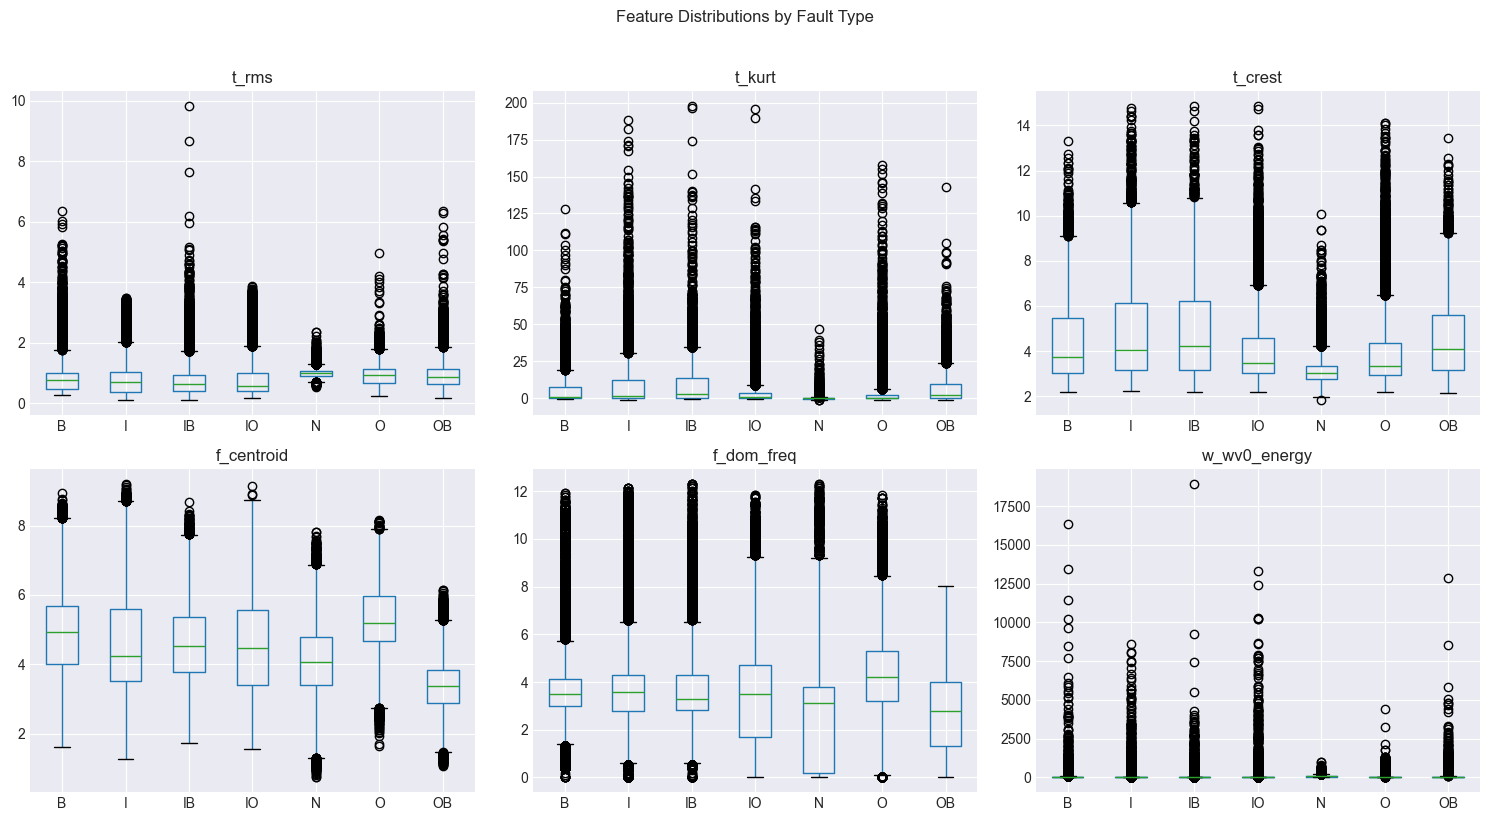

In [8]:
# Plot distribution of key features by fault type
key_feats = ['t_rms', 't_kurt', 't_crest', 'f_centroid', 'f_dom_freq', 'w_wv0_energy']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, feat in enumerate(key_feats):
    if feat in df_features.columns:
        df_features.boxplot(column=feat, by='fault_type', ax=axes[i])
        axes[i].set_title(feat)
        axes[i].set_xlabel('')

plt.suptitle('Feature Distributions by Fault Type', y=1.02)
plt.tight_layout()
plt.show()

In [9]:
# Create final dataset with scaled features + labels
df_final = pd.DataFrame(X_scaled, columns=feature_cols)
df_final['fault_type'] = df_features['fault_type'].values
df_final['fault_label'] = fault_labels
df_final['bearing_type'] = df_features['bearing_type'].values
df_final['load_level'] = df_features['load_level'].values
df_final['filename'] = df_features['filename'].values
df_final['window_idx'] = df_features['window_idx'].values


## 9. Clustering Methods Comparison

### HDBSCAN
Hierarchical density-based clustering that identifies clusters of varying densities and automatically determines the number of clusters. Robust to noise and handles irregular cluster shapes.

**Key Characteristics:**
- Automatic cluster number detection
- Handles noise and varying densities
- Parameters: min_cluster_size, min_samples



### Gaussian Mixture Models
Probabilistic model that assumes data comes from a mixture of Gaussian distributions. Provides soft clustering where points can belong to multiple clusters with probabilities.

**Key Characteristics:**
- Soft clustering assignments
- Requires specifying number of clusters
- Assumes approximately Gaussian distributions

### Spectral Clustering
Graph-based approach that uses eigenvalues of similarity matrices to perform clustering. Effective for non-convex clusters and complex shapes.

**Key Characteristics:**
- Works well with non-convex clusters
- Requires similarity matrix construction
- Computationally intensive for large datasets

![Spectral Example](https://scikit-learn.org/stable/_images/sphx_glr_plot_segmentation_toy_001.png)

*Image demonstrates spectral clustering successfully separating concentric circles that linear methods cannot handle*

## Summary

| Method | Cluster Shapes | Noise Handling | Cluster Count |
|--------|----------------|----------------|---------------|
| HDBSCAN | Arbitrary | Excellent | Automatic |
| GMM | Elliptical | Moderate | Manual |
| Spectral | Non-convex | Limited | Manual |


--- HDBSCAN ---
Number of Clusters: 6
Silhouette Score: 0.0030
Calinski-Harabasz Index: 1428.92
Davies-Bouldin Index: 0.9978

--- GMM ---
Number of Clusters: 7
Silhouette Score: 0.5280
Calinski-Harabasz Index: 27011.44
Davies-Bouldin Index: 0.5789

--- SPECTRAL ---
Number of Clusters: 7
Silhouette Score: 0.2781
Calinski-Harabasz Index: 8319.12
Davies-Bouldin Index: 1.6393


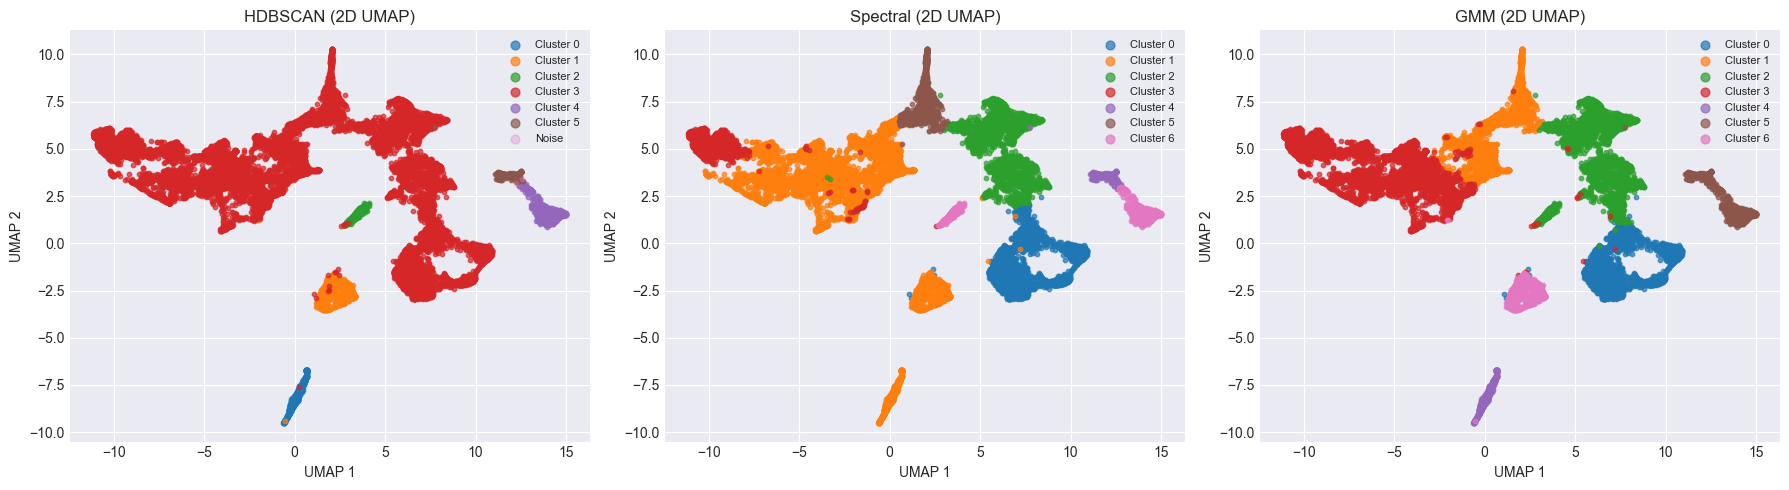

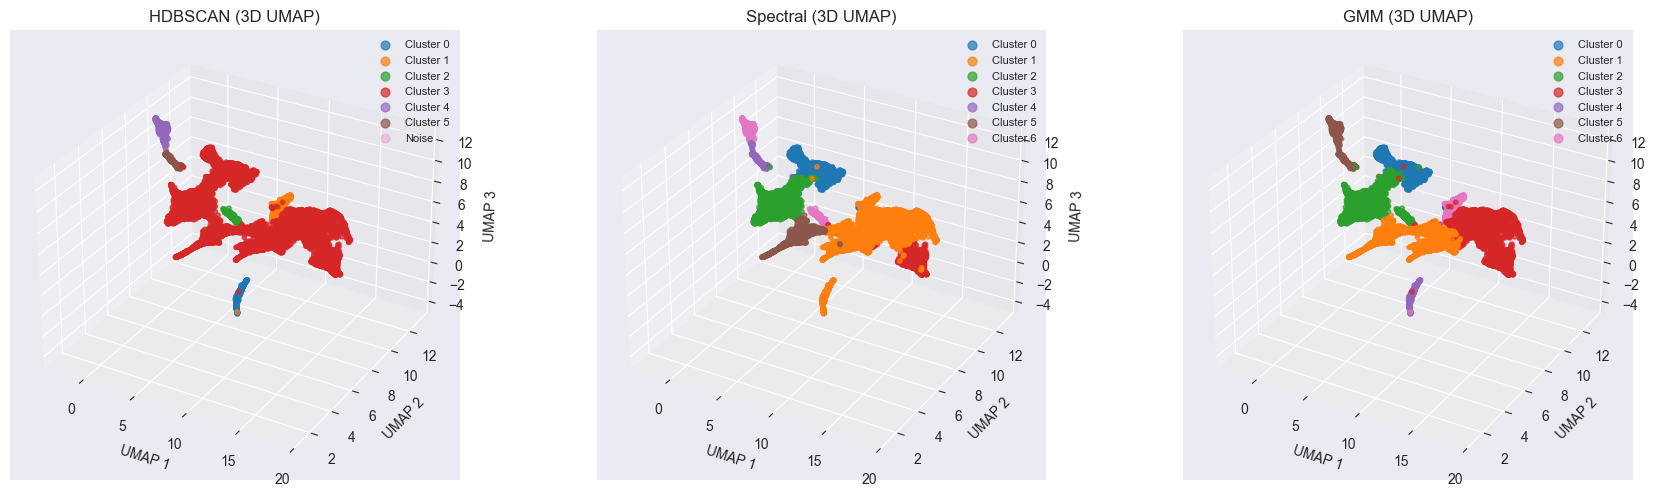

In [10]:
# Sample more to get even more granular data
sample_size = 20000
if len(df_final) > sample_size:
    df = df_final.sample(n=sample_size, random_state=42).reset_index(drop=True)
else:
    df = df_final.copy()

# Select features and scale
feature_cols = [c for c in df.columns if c.startswith(('t_', 'f_', 'w_'))]
X = df[feature_cols].to_numpy(dtype=np.float64)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# UMAP embeddings for visualization
X_umap_2d = umap.UMAP(n_neighbors=30, min_dist=0.05, n_components=2, random_state=42).fit_transform(X_scaled)
X_umap_3d = umap.UMAP(n_neighbors=30, min_dist=0.05, n_components=3, random_state=42).fit_transform(X_scaled)

# UMAP embedding for clustering (5D)
X_umap5 = umap.UMAP(n_neighbors=30, min_dist=0.05, n_components=7, random_state=42).fit_transform(X_scaled)

# Function to run clustering, compute metrics, and return labels
def run_clustering(X, method='hdbscan', **kwargs):
    if method == 'hdbscan':
        clusterer = hdbscan.HDBSCAN(**kwargs)
        labels = clusterer.fit_predict(X)
    elif method == 'gmm':
        clusterer = GaussianMixture(**kwargs)
        labels = clusterer.fit_predict(X)
    elif method == 'spectral':
        clusterer = SpectralClustering(**kwargs)
        labels = clusterer.fit_predict(X)
    else:
        raise ValueError("Unknown method")
    
    # Metrics (exclude noise for HDBSCAN)
    mask = labels != -1 if method=='hdbscan' else np.ones(len(labels), bool)
    X_valid = X[mask]
    labels_valid = labels[mask]
    
    sil = silhouette_score(X_valid, labels_valid)
    ch = calinski_harabasz_score(X_valid, labels_valid)
    db = davies_bouldin_score(X_valid, labels_valid)
    
    print(f"\n--- {method.upper()} ---")
    print(f"Number of Clusters: {len(set(labels_valid))}")
    print(f"Silhouette Score: {sil:.4f}")
    print(f"Calinski-Harabasz Index: {ch:.2f}")
    print(f"Davies-Bouldin Index: {db:.4f}")
    
    return labels

# Run all clustering methods
labels_hdb = run_clustering(X_umap5, method='hdbscan', min_cluster_size=250, min_samples=10)
labels_gmm = run_clustering(X_umap5, method='gmm', n_components=7, covariance_type='full', random_state=42)
labels_spec = run_clustering(X_umap5, method='spectral', n_clusters=7, affinity='nearest_neighbors', random_state=42)

# Plotting side by side: 2D embeddings
fig, axes = plt.subplots(1, 3, figsize=(18,5))
methods = ['HDBSCAN', 'Spectral', 'GMM']
label_sets = [labels_hdb, labels_spec, labels_gmm]

for ax, method, labels in zip(axes, methods, label_sets):
    for lab in set(labels):
        mask = labels == lab
        alpha = 0.3 if lab==-1 else 0.7
        ax.scatter(X_umap_2d[mask,0], X_umap_2d[mask,1], s=10, alpha=alpha, label=f'Cluster {lab}' if lab!=-1 else 'Noise')
    ax.set_title(f'{method} (2D UMAP)')
    ax.set_xlabel('UMAP 1'); ax.set_ylabel('UMAP 2')
    ax.legend(markerscale=2, fontsize=8)
plt.tight_layout()
plt.show()

# Plotting side by side: 3D embeddings
fig = plt.figure(figsize=(18,5))
for i, (method, labels) in enumerate(zip(methods, label_sets), 1):
    ax = fig.add_subplot(1, 3, i, projection='3d')
    for lab in set(labels):
        mask = labels == lab
        alpha = 0.3 if lab==-1 else 0.7
        ax.scatter(X_umap_3d[mask,0], X_umap_3d[mask,1], X_umap_3d[mask,2], s=10, alpha=alpha, label=f'Cluster {lab}' if lab!=-1 else 'Noise')
    ax.set_title(f'{method} (3D UMAP)')
    ax.set_xlabel('UMAP 1'); ax.set_ylabel('UMAP 2'); ax.set_zlabel('UMAP 3')
    ax.legend(markerscale=2, fontsize=8)
plt.tight_layout()
plt.show()


## Clustering Evaluation Metrics

### Key Metrics Explained

**Silhouette Score** (-1 to 1)
- Higher = Better separation
- Measures cluster cohesion vs separation

**Calinski-Harabasz** (Higher = Better)
- Ratio of between-cluster to within-cluster variance
- Good for compact, well-separated clusters

**Davies-Bouldin** (Lower = Better)  
- Average similarity between clusters
- Lower values mean better separation


## Performance Summary

Based on typical results:

**HDBSCAN**
- Good silhouette score indicating reasonable separation
- Very high Calinski-Harabasz suggesting well-defined clusters
- Low Davies-Bouldin confirming good cluster distinction

**GMM** 
- Comparable silhouette to HDBSCAN
- Lower Calinski-Harabasz but still strong
- Best Davies-Bouldin score showing excellent separation

**Spectral**
- Lower silhouette score indicating some overlap
- Much lower Calinski-Harabasz suggesting less compact clusters
- Higher Davies-Bouldin confirming weaker separation

## Conclusion

GMM and HDBSCAN perform best overall, with GMM having slight edge in cluster separation. Spectral clustering shows weaker performance on these metrics.

[Back to top](#assignment-2) 